In [35]:
import os
import json
import numpy as np
import xarray as xr
import proplot as pplt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d.art3d import Poly3DCollection,Line3DCollection

In [36]:
with open('/global/cfs/cdirs/m4334/sferrett/monsoon-kernels/scripts/configs.json','r',encoding='utf-8') as f:
    CONFIGS = json.load(f)
INTERIMDIR = CONFIGS['filepaths']['interim']
MODELS     = CONFIGS['models']
FIELDVARS  = CONFIGS['variables']['field']
LOCALVARS  = CONFIGS['variables']['local']
TARGETVAR  = CONFIGS['variables']['target']
LATRANGE   = CONFIGS['domain']['latrange']
LONRANGE   = CONFIGS['domain']['lonrange']
LEVRANGE   = CONFIGS['domain']['levrange']
SPLIT      = 'valid'

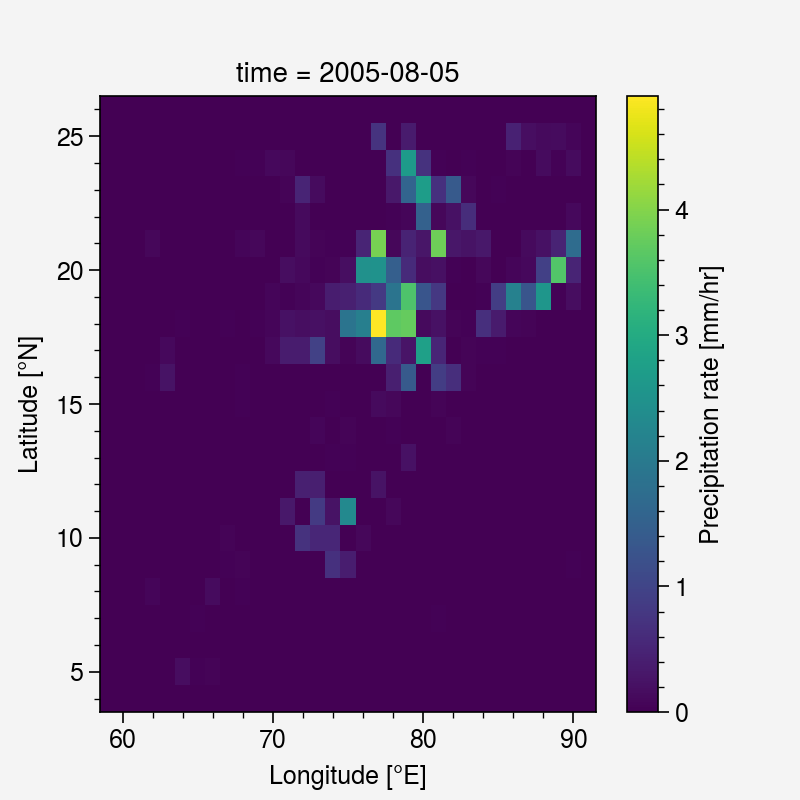

In [71]:
pr = xr.open_dataset(f'{INTERIMDIR}/pr.nc',engine='h5netcdf').pr

pr.isel(time=12600).plot()

In [72]:
def get_da(varname,filedir=INTERIMDIR):
    ds = xr.open_dataset(f'{filedir}/{varname}.nc',engine='h5netcdf')
    if 'time' in ds.dims:
        ds = ds.isel(time=12600)
    da = ds[varname]
    return da

def get_edges(lons,lats):
    dlon = float(np.median(np.diff(lons)))
    dlat = float(np.median(np.diff(lats)))
    lonedges = np.concatenate(([lons[0]-0.5*dlon],lons[:-1]+0.5*dlon,[lons[-1]+0.5*dlon]))
    latedges = np.concatenate(([lats[0]-0.5*dlat],lats[:-1]+0.5*dlat,[lats[-1]+0.5*dlat]))
    lonrange = (float(lonedges.min()),float(lonedges.max()))
    latrange = (float(latedges.min()),float(latedges.max()))
    X,Y = np.meshgrid(lonedges,latedges)
    return lonedges,latedges,lonrange,latrange,X,Y

def prep_basemap(ax,lonrange,latrange):
    m = Basemap(
        llcrnrlon=lonrange[0],urcrnrlon=lonrange[1],llcrnrlat=latrange[0],urcrnrlat=latrange[1],
        projection='cyl',resolution='i',fix_aspect=False,ax=ax)
    polys = [list(p.get_coords()[:,:2])+[p.get_coords()[0,:2]] for p in m.landpolygons]
    land  = PolyCollection(polys,edgecolor='k',facecolor='gray',linewidths=0.2,closed=False)
    return m,land

def set_3D_style(ax,lonrange,latrange,zmin,zmax):
    ax.set_proj_type('persp')
    ax.set_box_aspect(None,zoom=1.1)
    ax.view_init(azim=-60,elev=20)
    ax.set_xlim(lonrange[0],lonrange[1])
    ax.set_ylim(latrange[0],latrange[1])
    ax.set_zlim(zmax,zmin)
    ax.grid(False)
    for axis in (ax.xaxis,ax.yaxis,ax.zaxis):
        axis.pane.set_visible(False)
        axis._axinfo['grid']['linewidth'] = 0
        axis.line.set_color((0,0,0,0))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

def add_layer_outline(ax,lonrange,latrange,z,color='k',linewidth=3.0):
    lonmin,lonmax = lonrange
    latmin,latmax = latrange
    ax.plot([lonmin,lonmax,lonmax,lonmin,lonmin],
            [latmin,latmin,latmax,latmax,latmin],
            zs=[float(z)]*5,color=color,linewidth=linewidth)

def add_layer_rim(ax,lonrange,latrange,z,thickness=3.0,color='k'):
    lonmin,lonmax = lonrange
    latmin,latmax = latrange
    zmin,zmax     = float(z),float(z)+float(thickness)
    faces = [
        [(lonmin,latmin,zmin),(lonmax,latmin,zmin),(lonmax,latmin,zmax),(lonmin,latmin,zmax)],
        [(lonmax,latmin,zmin),(lonmax,latmax,zmin),(lonmax,latmax,zmax),(lonmax,latmin,zmax)],
        [(lonmax,latmax,zmin),(lonmin,latmax,zmin),(lonmin,latmax,zmax),(lonmax,latmax,zmax)],
        [(lonmin,latmax,zmin),(lonmin,latmin,zmin),(lonmin,latmin,zmax),(lonmin,latmax,zmax)]]
    ax.add_collection3d(Poly3DCollection(faces,facecolor=color,edgecolor=color,linewidths=0.0))
    
def plot(varname,cmap,plotlevs=[900,800,700],baselev=1000.0):
    da = get_da(varname)
    lonedges,latedges,lonrange,latrange,X,Y = get_edges(da.lon.values,da.lat.values)
    fig,ax = plt.subplots(1,1,figsize=(3,3),subplot_kw={'projection':'3d'})
    m,land = prep_basemap(ax,lonrange,latrange)
    if da.ndim==3:
        basez = float(da.sel(lev=baselev,method='nearest').lev.values)
        zall  = [basez] + [float(da.sel(lev=lev,method='nearest').lev.values) for lev in plotlevs]
        zmin  = float(np.min(zall))
        zmax  = float(np.max(zall))
    else:
        basez = 0.0
        zmin  = -1.0
        zmax  =  1.0+3.0
    ax.add_collection3d(land,zs=basez)
    set_3D_style(ax,lonrange,latrange,zmin,zmax)
    if da.ndim==3:
        dalist  = []
        zlist   = []
        arrlist = []
        for lev in plotlevs:
            daatlev = da.sel(lev=lev,method='nearest')
            z       = float(daatlev.lev.values)
            dalist.append(daatlev)
            zlist.append(z)
            arr = daatlev.values
            arrlist.append(arr[np.isfinite(arr)].ravel())
        arrs = np.concatenate(arrlist) if len(arrlist) else np.array([0.0,1.0])
        norm = mcolors.Normalize(vmin=float(arrs.min()),vmax=float(arrs.max()))
        cmapobj = plt.get_cmap(cmap)
        for dai,z in zip(dalist,zlist):
            cell = np.ma.masked_invalid(dai.values)
            facecolors = cmapobj(norm(cell))
            Z = np.full_like(X,z,dtype=float)
            ax.plot_surface(X,Y,Z,facecolors=facecolors,rstride=1,cstride=1,linewidth=0,antialiased=False,shade=False)
            add_layer_rim(ax,lonrange,latrange,z)
        add_layer_rim(ax,lonrange,latrange,basez)
    else:
        cell = np.ma.masked_invalid(da.values)
        vmin = float(cell.min()) if np.isfinite(cell.min()) else 0.0
        vmax = float(cell.max()) if np.isfinite(cell.max()) else 1.0
        norm = mcolors.Normalize(vmin=vmin,vmax=vmax)
        cmapobj = plt.get_cmap(cmap)
        facecolors = cmapobj(norm(cell))
        Z = np.full_like(X,basez,dtype=float)
        ax.plot_surface(X,Y,Z,facecolors=facecolors,rstride=1,cstride=1,linewidth=0,antialiased=False,shade=False)
        add_layer_outline(ax,lonrange,latrange,basez)
    plt.subplots_adjust(left=0,right=1,bottom=0,top=1)
    plt.show()

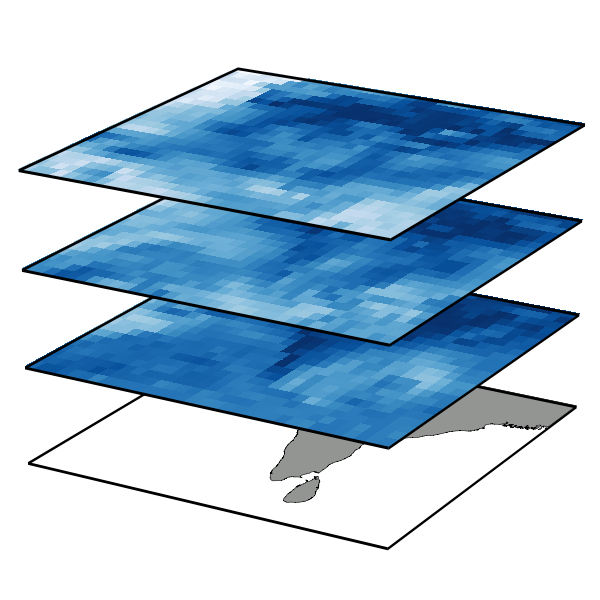

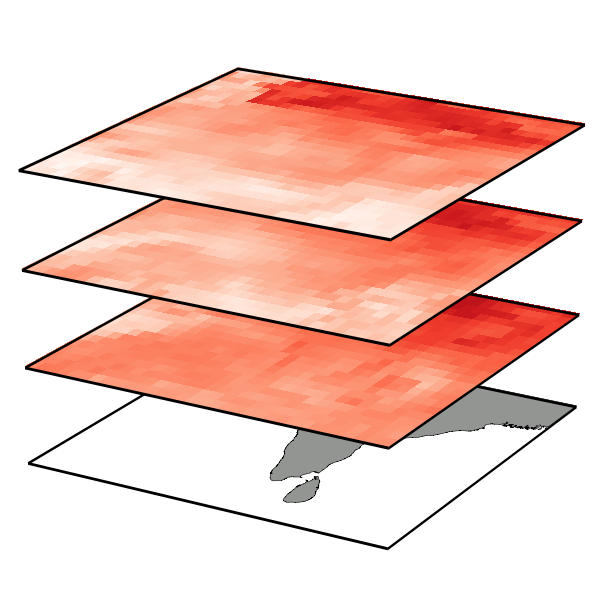

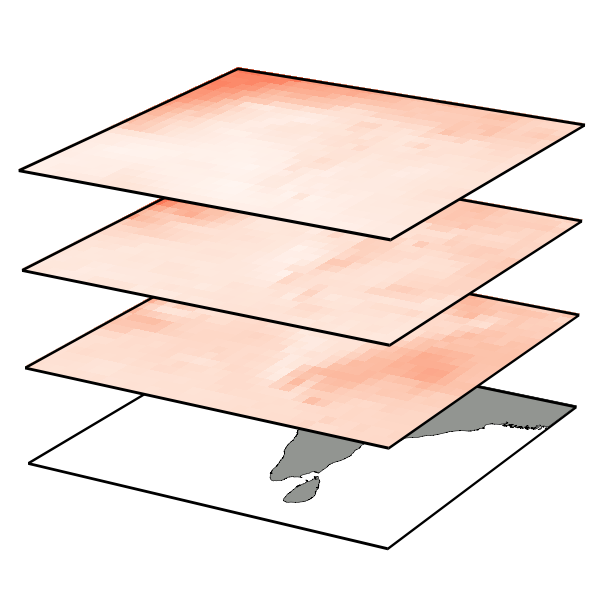

In [89]:
plot('rh','blues')
plot('thetae','reds')
plot('thetaestar','reds')

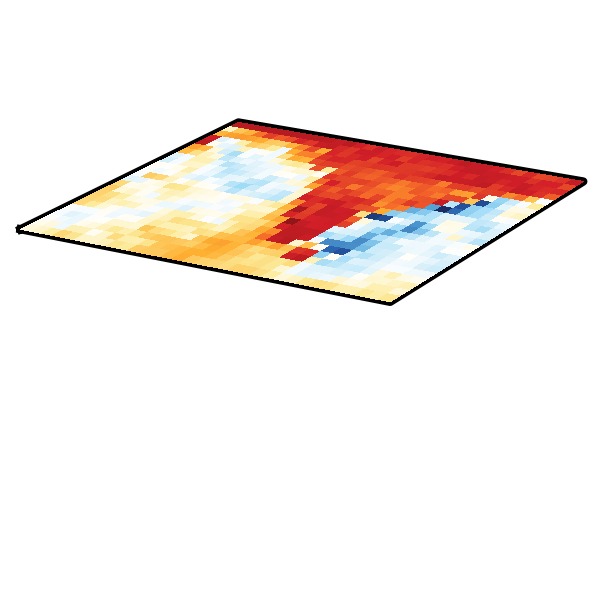

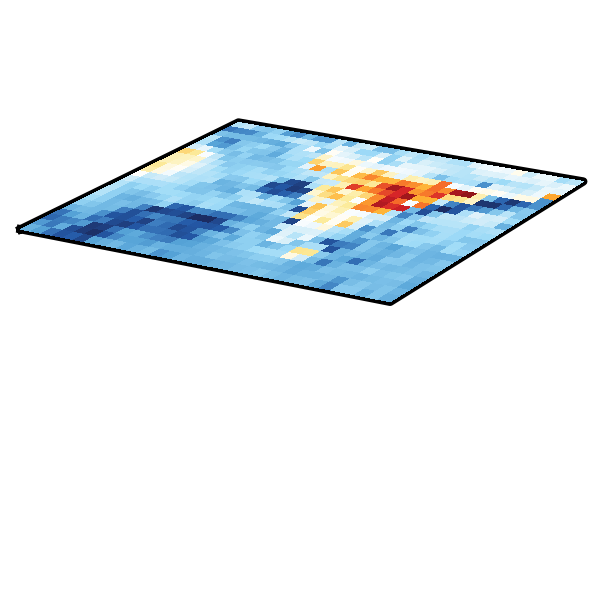

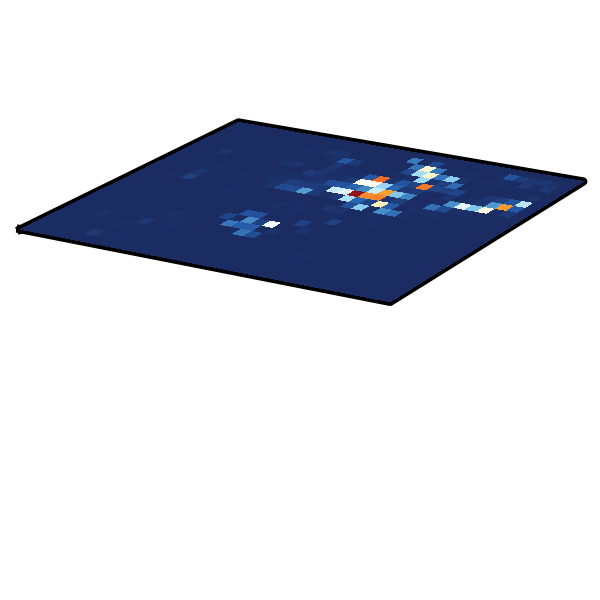

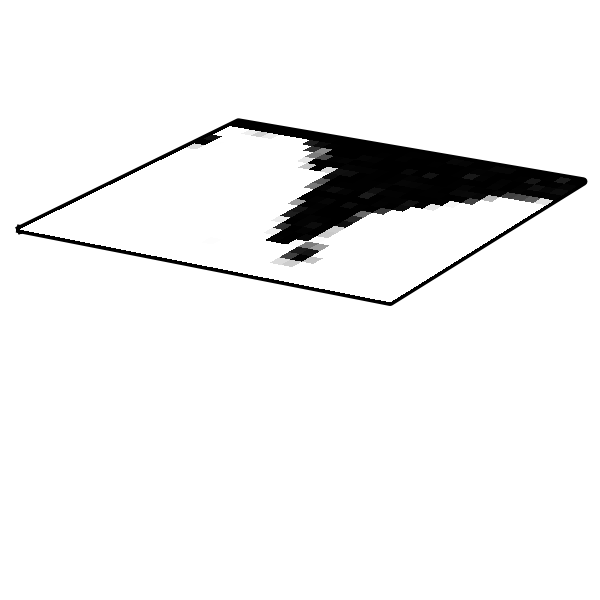

In [88]:
plot('lhf','coldhot')
plot('shf','coldhot')
plot('pr','coldhot')
plot('lf','binary')